In [19]:
import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import tensorflow as tf
import altair as alt
import collections
from sklearn.model_selection import train_test_split


from src.clean_data import clean_books, clean_reviews, scale_data, review_map_id
from src.load_data import read_reviews, read_books
from src.item_recommender import ItemRecommender
from src.CFModel import CFModel, build_model, compute_scores, book_neighbors, user_recommendations

In [2]:
books = pd.read_csv('data/cleaned_books_mystery.csv')

In [3]:
books.set_index('book_id', drop=True, inplace=True)

In [4]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178443 entries, 10000063 to 9999847
Data columns (total 10 columns):
title                 178443 non-null object
num_pages             178443 non-null int64
is_ebook              178443 non-null int64
link                  178443 non-null object
average_rating        178443 non-null float64
ratings_count         178443 non-null int64
text_reviews_count    178443 non-null int64
author_id             178443 non-null int64
publisher             125093 non-null object
similar_books         178443 non-null object
dtypes: float64(1), int64(5), object(4)
memory usage: 15.0+ MB


In [5]:
reviews = pd.read_csv('data/cleaned_reviews_mystery.csv')

In [6]:
len(books)

178443

In [7]:
reviews.head()

,review_id,user_id,book_id,rating,timestamp,n_votes,n_comments,old_user_id,old_book_id
0,d23dc89ab32cd864e54d18369751163b,158142,63529,3,2001-01-01 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,196084
1,c7613da4cbd48baa83efec99b4dd6a41,158142,163000,3,2001-01-11 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,79030
2,469b9d160ad68ce84b6cac4585fb226a,158142,140825,4,2001-01-25 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,442783
3,9f4fd2c20177f66fe5832ec299fb4bbf,158142,145138,2,2001-01-29 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,552719
4,0c7a29c98c4f11b409235d9c22a2455b,158142,85564,4,2001-02-02 00:00:00,1,0,d889b42d9eb7b80e02f24830e27c6389,238117


In [8]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688495 entries, 0 to 1688494
Data columns (total 9 columns):
review_id      1688495 non-null object
user_id        1688495 non-null int64
book_id        1688495 non-null int64
rating         1688495 non-null int64
timestamp      1688495 non-null object
n_votes        1688495 non-null int64
n_comments     1688495 non-null int64
old_user_id    1688495 non-null object
old_book_id    1688495 non-null int64
dtypes: int64(6), object(3)
memory usage: 115.9+ MB


### CF baseline with normal gradient descent

In [21]:
# model_base = build_model(reviews, embedding_dim=30, init_stddev=0.05, 
#                     regularization_coeff=0.0,
#                     gravity_coeff=0.0, optimizer = tf.train.GradientDescentOptimizer)

In [ ]:
model_base.train(num_iterations=50)

### CF model with adam optimizer

In [13]:
# matrix factorization without regularization with adam optimizer
# adam optimizer -> adaptive moment estimation with changing learning rate 
# https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

model_adam = build_model(reviews, embedding_dim=30, init_stddev=0.05, 
                    regularization_coeff=0.0,
                    gravity_coeff=0.0)

 iteration 50: train_error=0.243675, regularization_error=0.000000, gravity_loss=0.000000, test_error=31.052099

[{'train_error': 0.24367544,
  'regularization_error': 0.0,
  'gravity_loss': 0.0,
  'test_error': 31.0521}]

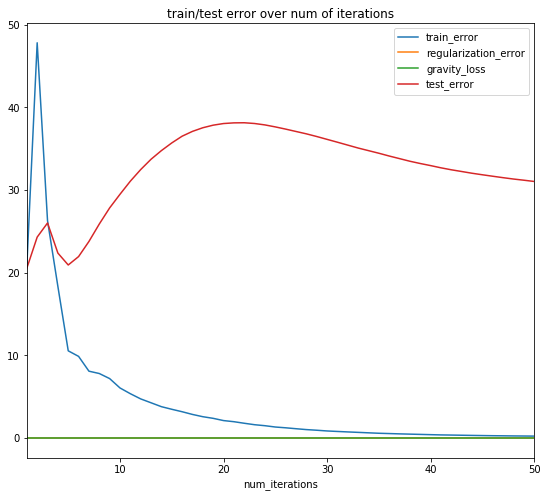

In [14]:
model_adam.train(num_iterations=50)

### CF model with regularization, gravity and adam optimizer

In [11]:
# A CFModel object that uses a regularized loss, gravity loss with adam optimizer
model = build_model(reviews, embedding_dim=30, init_stddev=0.05, 
                    regularization_coeff=0.1,
                    gravity_coeff=1.0)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Instructions for updating:
To construct input pipelines, use the `tf.data` module.


 iteration 50: train_error=0.182489, regularization_error=0.572702, gravity_loss=0.313470, test_error=9.5439936

[{'train_error': 0.18248917,
  'regularization_error': 0.5727021,
  'gravity_loss': 0.3134698,
  'test_error': 9.543993}]

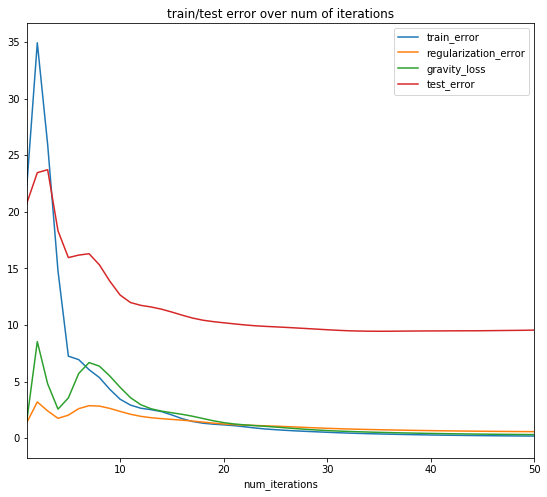

In [12]:
model.train(num_iterations=50)

### get recommendations for a given user

In [22]:
#example with user 'd889b42d9eb7b80e02f24830e27c6389'
user_id = 'd889b42d9eb7b80e02f24830e27c6389'
user_recommendations(books, reviews, model, user_id, measure='cosine', k=10)

The highest recommendations for user d889b42d9eb7b80e02f24830e27c6389.


,cosine score,titles,is_ebook,average_rating,ratings_count
book_id,,,,,
442783,0.8637782335281372,"The Empty Hours (87th Precinct, #15)",0,3.75,343
592177,0.8270640969276428,Straight Cut (Hard Case Crime #21),0,3.18,212
137556,0.7606433629989624,Fade to Blonde (Hard Case Crime #2),0,3.6,758
629521,0.72339928150177,Wild to Possess/A Taste for Sin,0,4.25,26
196084,0.7136276960372925,Night Walker (Hard Case Crime #16),0,3.41,228
1061855,0.7128523588180542,Cuba Libre,0,3.62,135
595894,0.7119606733322144,The Killing Moon,0,3.42,431
190523,0.705325722694397,Suicide Squeeze,0,3.83,255
236212,0.7011841535568237,From the Corner of His Eye,0,4.0,271


### get neighbors of a book which contains a given substring

In [23]:
#example with book 'Harry Potter'
title_substring ='Harry Potter'
book_neighbors(books, reviews, model, title_substring, measure='cosine', k=10)

[25572694]
Nearest neighbors of : Harry Potter and the Half-Blood Prince by J.K. Rowling | Summary & Study Guide.


,cosine score,titles,is_ebook,average_rating,ratings_count
book_id,,,,,
25572694,0.9999998807907104,Harry Potter and the Half-Blood Prince by J.K. Rowling | Summary & Study Guide,1,5.0,2
9149773,0.999690055847168,"L.A. Dead (Stone Barrington, #6)",1,3.93,11
29057198,0.9995408058166504,Spells and Scones,0,4.1,14
25561901,0.9995187520980835,The Adventures of Sherlock Holmes,0,4.3,4
26005955,0.9993808269500732,The Job:,0,3.95,8
31433541,0.9992083311080933,Ice Wolf,1,4.0,9
10302490,0.9986937046051025,Suspense Magazine June 2010,1,4.9,10
33258453,0.9984890222549438,Lie to Me,0,3.84,2197
20448475,0.9734480381011963,"Gray Lady, Lady Gray",1,4.0,7


In [ ]:
title_substring ='The Midsummer Crown'
book_neighbors(books, reviews, model, title_substring, measure='cosine', k=10)

In [ ]:
books.loc[10057976]

In [ ]:
books.loc[12263607]

### inspect neighbor clustering

In [ ]:
def book_embedding_norm(models):
    """
    visualizes the norm and number of ratings of the book
    Args:
        model: a MFmodel object
    """
    if not isinstance(models, list):
        models = [models]
    df=pd.DataFrame({
        'title': cleaned_books1['title'],
        'average_rating': cleaned_books1['average_rating'],
        'ratings_count':cleaned_books1['ratings_count']
    })
    charts = []
    brush = alt.selection_interval()
    for i, model in enumerate(models):
        norm_key = 'norm' +str(i)
        df[norm_key] = np.linalg.norm(model.embeddings['book_id'], axis=1)
        nearest = alt.selection(
                type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
                empty='none')
        base = alt.Chart().mark_circle().encode(
                x='ratings_count',
                y=norm_key,
               color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
            ).properties(
            selection=nearest).add_selection(brush)
        text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='ratings_count', y=norm_key,
        text=alt.condition(nearest, 'title', alt.value('')))
        charts.append(alt.layer(base, text))
    return alt.hconcat(*charts, data=df)
    
    

In [ ]:
book_embedding_norm(model)

In [ ]:
from scipy.sparse import csr_matrix
# csr_matrix((train_reviews.rating.values, (train_reviews.user_id.values, train_reviews.book_id.values)), 
#            shape=(len(train_reviews.user_id.unique()), len(train_reviews.book_id.unique()))).toarray()

#rating matrix will be too sparse if we convert the rating data into a pd pivot table 
#rating_mat = pd.pivot_table(train_reviews, values=['rating'], index=['user_id'], columns =['book_id'])